This notebook is used to validate the different convolution functions that I could use. 

In [1]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

<h2> Scipy <h2>

First we start with the scipy library. I found a question in stack overflow that solved a convolution error in this library in particular:
https://stackoverflow.com/questions/47373050/scipy-signal-convolve-gives-different-result-than-manual-computation-of-convolut?rq=3

We write three variations of convolutions that can be done (each improving on the previous one), and compare them with a mathematically found solution. 

In [2]:
def c_tissue(IRF_values, pchip_pl):
    """

    """
    num_points = len(IRF_values) 

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='same')[:num_points]

    return simulated_c_tissue_values


def c_tissue_norm(IRF_values, pchip_pl, dt):
    """
    In this case we normalize
    """
    num_points = len(IRF_values) 

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='same')[:num_points]

    # Normalize the convolution result
    normalized_result_tensor = simulated_c_tissue_values * dt # Multiply by dt

    return normalized_result_tensor


def c_tissue_norm_full(IRF_values, pchip_pl, dt):
    """
    In this case we normalize and also use the 'full' mode
    """
    num_points = len(IRF_values) 

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='full')[:num_points]

    # Normalize the convolution result
    normalized_result_tensor = simulated_c_tissue_values * dt # Multiply by dt

    return normalized_result_tensor

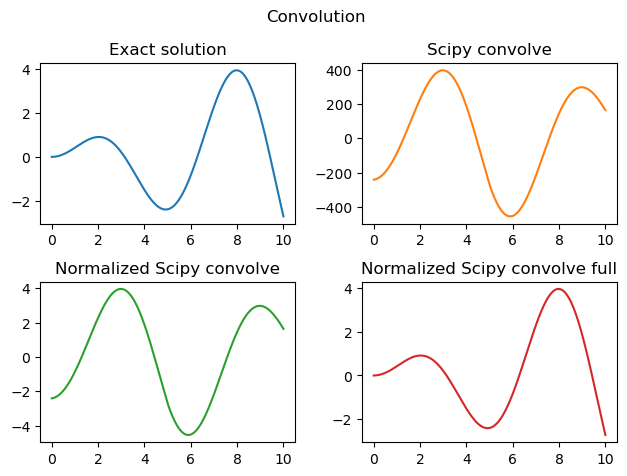

In [3]:
n = 1000
t = np.linspace(0, 10, n)
dt = t[1] - t[0]
f = np.sin(t)
g = np.cos(t)
conv = 0.5 * t * np.sin(t) # Exact solution
#conv2 = scipy.signal.convolve(f, g, mode='full')[:n] * dt
conv2 = c_tissue(f, g)
conv3 = c_tissue_norm(f, g, dt)
conv4 = c_tissue_norm_full(f, g, dt)

#Plot all four signals as four plots in a single figure
fig, axs = plt.subplots(2, 2)
fig.suptitle('Convolution')
axs[0, 0].plot(t, conv)
axs[0, 0].set_title('Exact solution')
axs[0, 1].plot(t, conv2, 'tab:orange')
axs[0, 1].set_title('Scipy convolve')
axs[1, 0].plot(t, conv3, 'tab:green')
axs[1, 0].set_title('Normalized Scipy convolve')
axs[1, 1].plot(t, conv4, 'tab:red')
axs[1, 1].set_title('Normalized Scipy convolve full')

# Put more spacing between plots
fig.tight_layout(pad=1.0)

plt.show()


Now we try to use the defined interpolation functions so as to check that these don't change the data in some way that leads to an incorrect convolution

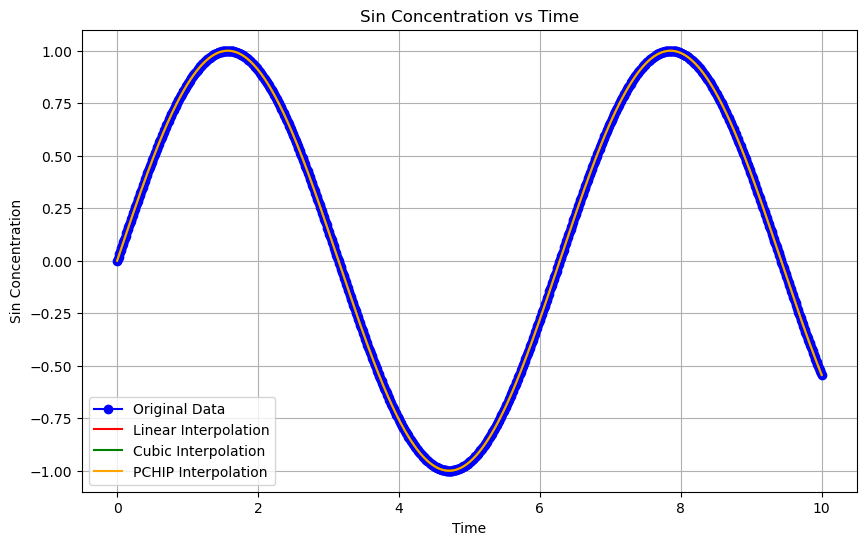

In [4]:
from data.Data_simulation import plot_interpolations
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator

def equidistant_interpolation(rtim_list, pl_list, num_points):
    """
    Performs equidistant interpolation on the given rtim_list and pl_list.

    Parameters:
    rtim_list (list): The original list of non-equidistant timepoints.
    pl_list (list): The list of plasma concentration values corresponding to rtim_list.
    num_points (int): The number of desired equidistant points.

    Returns:
    tuple: Lists containing the new equidistant timepoints and interpolated plasma values.
    """
    # Generate equidistant timepoints
    min_time = min(rtim_list)
    max_time = max(rtim_list)
    equidistant_rtim = np.linspace(min_time, max_time, num_points)

    # Perform linear interpolation using numpy
    linear_interp_pl = np.interp(equidistant_rtim, rtim_list, pl_list)

    # Perform cubic interpolation using scipy (as an alternative example)
    cubic_interp_func = interp1d(rtim_list, pl_list, kind='cubic', fill_value="extrapolate")
    cubic_interp_pl = cubic_interp_func(equidistant_rtim)

    # Perform monotonic cubic interpolation using PchipInterpolator
    pchip_interp_func = PchipInterpolator(rtim_list, pl_list)
    pchip_interp_pl = pchip_interp_func(equidistant_rtim)

    return equidistant_rtim, linear_interp_pl, cubic_interp_pl, pchip_interp_pl

num_equidistant_points = 5000
new_rtim, linear_f, cubic_f, pchip_f = equidistant_interpolation(t,
                                                          f,
                                                          num_equidistant_points)

plot_interpolations(t, 
                    f, 
                    new_rtim, linear_f, cubic_f, pchip_f, 'Sin')

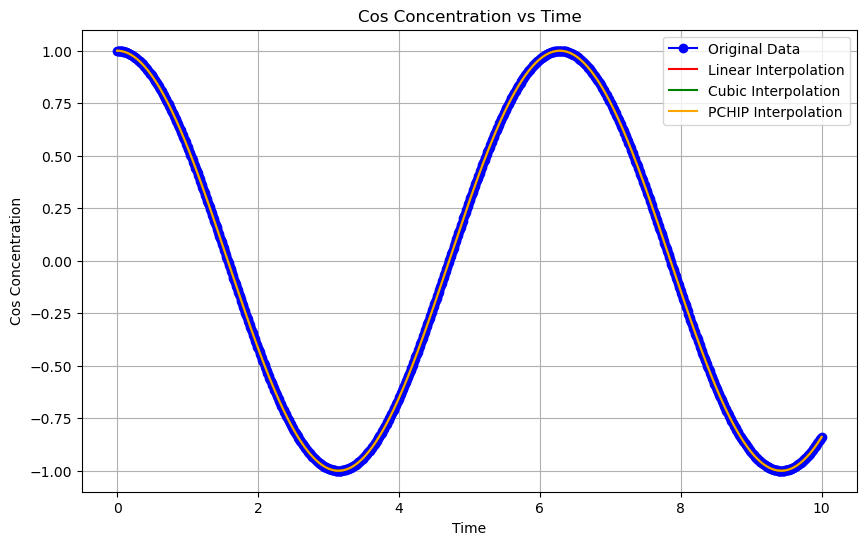

In [5]:
new_rtim, linear_g, cubic_g, pchip_g = equidistant_interpolation(t,
                                                          g,
                                                          num_equidistant_points)

plot_interpolations(t, 
                    g, 
                    new_rtim, linear_g, cubic_g, pchip_g, 'Cos')

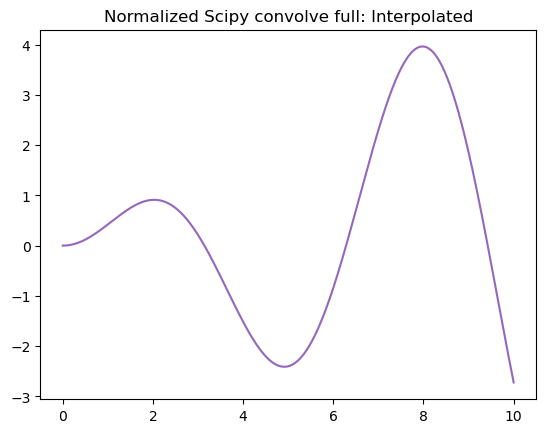

In [6]:
dt /= 5
conv = c_tissue_norm_full(pchip_f, pchip_g, dt)

plt.plot(new_rtim, conv, 'tab:purple')
plt.title('Normalized Scipy convolve full: Interpolated')
plt.show()

So it looks like using equidistant_interpolation with more datapoints does not change the output and the convolution is still correct. 

<h3> Exponential distribution <h3>

Now we also try to validate that this should work on distributions which are not equidistant, and where the timesteps increase with their index.

In [7]:
t_exp = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85]

#Scale the timepoints to a similar range as the sin and cos functions used previously
for i in t_exp:
    t_exp[t_exp.index(i)] = i /9
print(t_exp)


[0.013888888888888888, 0.03240744444444445, 0.041666666666666664, 0.05092588888888889, 0.06481477777777778, 0.08333333333333333, 0.1018518888888889, 0.16666666666666666, 0.2777777777777778, 0.3888888888888889, 0.5, 0.6944444444444444, 0.9722222222222222, 1.3888888888888888, 1.9444444444444444, 2.7777777777777777, 3.888888888888889, 5.0, 6.111111111111111, 7.222222222222222, 8.333333333333334, 9.444444444444445]


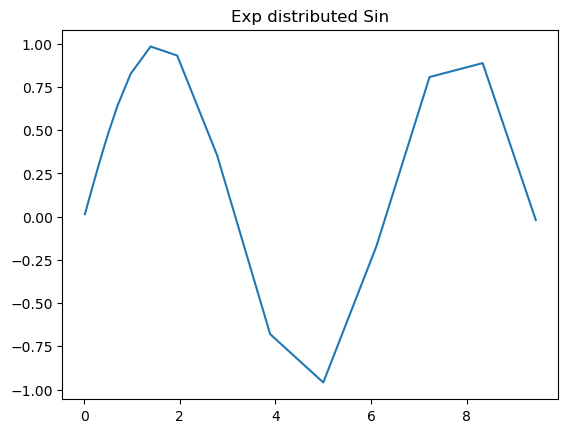

In [8]:
f_exp = np.sin(t_exp)
g_exp = np.cos(t_exp)

plt.plot(t_exp, f_exp, 'tab:blue')
plt.title('Exp distributed Sin')
plt.show()

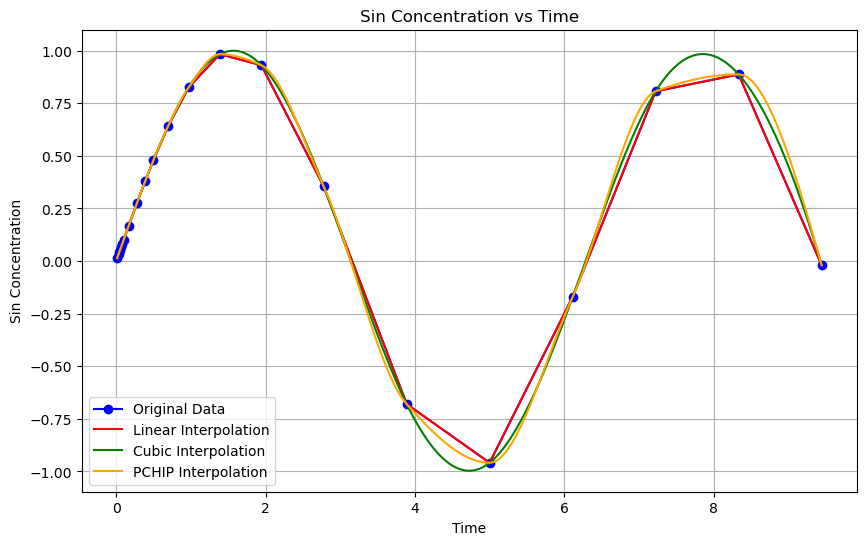

In [9]:
num_equidistant_points = 5000
new_rtim, linear_f, cubic_f, pchip_f = equidistant_interpolation(t_exp,
                                                          f_exp,
                                                          num_equidistant_points)

plot_interpolations(t_exp, 
                    f_exp, 
                    new_rtim, linear_f, cubic_f, pchip_f, 'Sin')

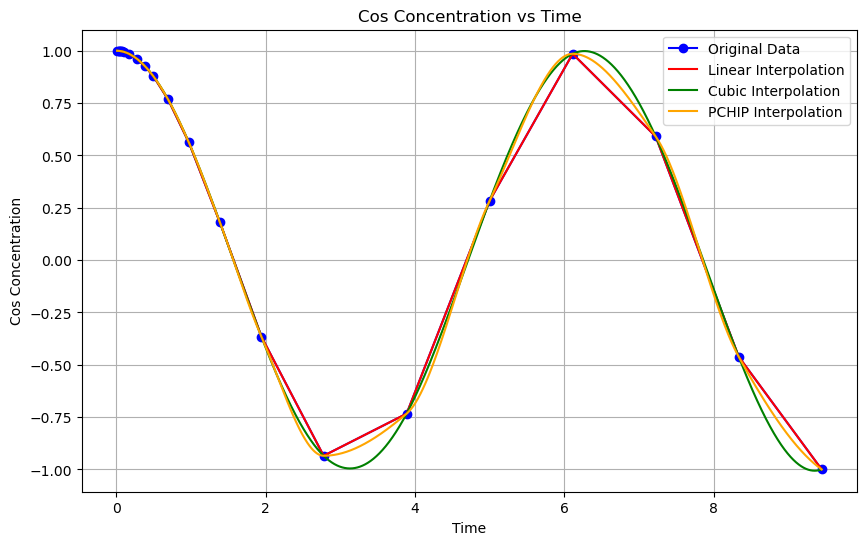

In [10]:
num_equidistant_points = 5000
new_rtim, linear_f, cubic_f, pchip_f = equidistant_interpolation(t_exp,
                                                          g_exp,
                                                          num_equidistant_points)

plot_interpolations(t_exp, 
                    g_exp, 
                    new_rtim, linear_f, cubic_f, pchip_f, 'Cos')

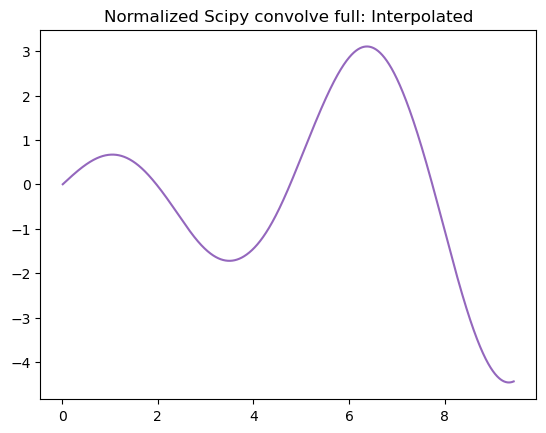

In [11]:
dt = new_rtim[1] - new_rtim[0]
conv = c_tissue_norm_full(pchip_f, pchip_g, dt)

plt.plot(new_rtim, conv, 'tab:purple')
plt.title('Normalized Scipy convolve full: Interpolated')
plt.show()

Again, it looks like using equidistant_interpolation on functions that are not equidistant and have an exponential time distribution (as in the given data) does lead to correct results. 

<h2> Torch <h2>

In [12]:
def c_tissue(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated TAC values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated TAC values.
    """
    # Convert lists to PyTorch tensors and add required dimensions for conv1d
    IRF_tensor = torch.tensor(IRF_values).float().unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl).float().unsqueeze(0).unsqueeze(0)

    # Perform the convolution using PyTorch's conv1d function
    # The groups argument ensures that each input channel is convolved with its own filter (IRF_tensor)
    result_tensor = F.conv1d(pchip_pl_tensor, IRF_tensor, padding='same', groups=1)

    # Normalize the IRF tensor
    normalized_result_tensor = result_tensor * dt # Multiply by dt

    # Remove the extra dimensions and convert the tensor back to a list
    simulated_tac_values = normalized_result_tensor.squeeze().tolist()

    return simulated_tac_values

/var/folders/zv/0t7_y4d14yg29z856cdmpbvc0000gn/T/ipykernel_1926/4010758999.py:18: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1009.)
  result_tensor = F.conv1d(pchip_pl_tensor, IRF_tensor, padding='same', groups=1)


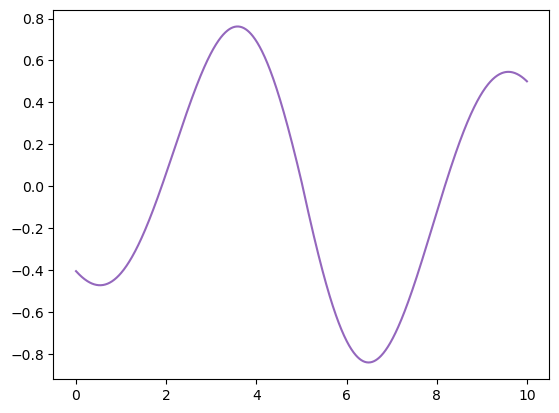

In [13]:
conv5 = c_tissue(f, g, dt)

plt.plot(t, conv5, 'tab:purple')
plt.show()

The results are the same as the normalized convolution in scipy using mode: 'valid'. The only thing to be done is find how to do the 'full' mode, in case that it is correct indeed. 